# Python for Fantasy Football - Feature Engineering for Machine Learning
Welcome to part 9 of my Python for Fantasy Football series! Since __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__ we have been attempting to create our own expected goals model from the __[StatsBomb NWSL and FA WSL data](https://github.com/statsbomb/open-data)__ using machine learning. If you missed any of the previous articles or need a refresher, links are below:

__[Part 1](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__
, __[Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-matchup-adjustment/)__, __[Part 3](http://www.fantasyfutopia.com/python-for-fantasy-football-getting-and-cleaning-data/)__, __[Part 4](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__, __[Part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__, __[Part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__, __[Part 7](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__, __[Part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__

In __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__ I outlined a general process for creating machine learning models as follows:
- Gather some data
- Clean the data
- Choose a modelling approach
- Feature engineering
- Train the model
- Evaluate the model
- Tune the model hyperparameters to improve performance
- Make final predictions

So far, we have investigated different modelling approaches, looking at some strategies for __[dealing with class imbalance](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__ in our data before learning __[how to train a random forest classifier and interpret the results](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__. To make things easier, I did some preliminary feature engineering in part 5, choosing to throw out a lot of the columns from StatsBomb's original dataset. I was able to do this because I already had quite a bit of knowledge about xG models, so I had a good idea of what features I should and shouldn't include. Since feature engineering is vitally important to creating good machine learning models, I wanted to use this article to justify the choice of initial features, as well as think about additional features we could add to help potentially improve things further.

Before we get started, I wanted to stress that in most real-world machine learning problems you often won't have any knowledge of the domain you are working with. Indeed, making assumptions before creating models could end up being quite damaging. I therefore suggest a slightly modified approach to the one above when working on future machine learning problems:
- Gather some data
- Choose a modelling approach (if in doubt, use a random forest for problems that don't require deep learning)
- Clean the data to handle categorical data and missing values
    - Only carry out essential cleaning at this stage to get the model to run without any errors, don't carry out any feature engineering yet
- Train the model
- Evaluate the model
- Use the results to carry out feature engineering
    - Learn more about the domain at this stage, e.g. what is this feature, does it make sense that it's important etc
- Tune the model hyperparameters to improve performance
- Make final predictions

In [1]:
# Reloads modules automatically in case there are any changes
# See https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 2

# Show matplotlib plots without having to call .show()
%matplotlib inline

In [2]:
# Import everything else
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from collections import defaultdict
import matplotlib.pyplot as plt
from rfpimp import *
import scipy
from scipy.cluster import hierarchy as hc

## Choosing model features
I wanted to take a step back here and look at the raw data from StatsBomb to show you exactly what features were present in the initial dataset. As mentioned already I chose to remove some of these before training any models, so I wanted to go through each feature and justify the reasons for including or omitting it from the input data. The code below will import the raw data and filter it to show just the columns that aren't currently being used.

In [3]:
# Import raw data to justify inital feature selection
np_shots_raw = pd.read_csv('np_shots_raw.csv')

# Filter out the columns we actually used for our model
np_shots_unused = np_shots_raw.drop(['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                                     'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected',
                                     'duration'], axis=1)

# Nice function to view an example of the data with all columns shown (in case you have lots of them!)
# To do this, the columns are transposed into rows instead
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head().transpose())

display_all(np_shots_unused)

,0,1,2,3,4
event_type,shot,shot,shot,shot,shot
id,be76791e-ddde-4814-9af2-51435b504b33,dc22d90c-9fb4-4376-aa2a-975918e5b554,dd0027d6-0bba-4c2c-8f70-d336737ef1ff,80c97350-d5e8-44c0-a2f2-93ca1085ff58,c3decc71-9395-4ab0-b85f-40e13bbc619b
index,44,359,371,388,649
period,1,1,1,1,1
timestamp,01:37.7,13:06.4,13:36.6,14:01.5,23:18.7
minute,1,13,13,14,23
second,37,6,36,1,18
possession,5,28,29,30,47
possession_team,Chelsea LFC,Chelsea LFC,West Ham United LFC,Chelsea LFC,Chelsea LFC
off_camera,False,False,False,False,False


### Features that were removed
- event_type - Always equals shot, so no point including it.
- id, index - These are just so we can link the shots to other non-shot data.
- period, timestamp, minute, second, possession - It's possible that these would actually have some predictive value, e.g. if late goals are more likely due to fatigue etc (all else being equal). However, with such a small number of observations I thought it would be better to avoid including a time component in the model. Feel free to try using one if you like and see what happens!
- possession_team, team, player, position - Clearly these might actually influence the model a bit; not all players are equally good at shooting from long range etc. However, we would need a lot of data to justify using player skill in a model.
- off_camera - There is only one example of off_camera=True in the dataset, and all of the important values (shot location etc) appear to have been recorded anyway for that observation.
- statsbomb_xg, outcome - Obviously we don't want to cheat and include these!
- type - The two possible values are 'open play' or 'free kick', which we are already capturing via the 'play_pattern' column.
- start_location, key_pass_id - We turned these into new features; 'distance', 'angle' and 'assisted'.
- end_location - Whether to include this or not depends on how you define xG. Do we want to know the expected value of a shot from 30 yards out, or do we want to know the value of a 30 yard screamer heading towards the top corner? In reality __[it might be useful to have both models](https://statsbomb.com/2018/11/a-new-way-to-measure-keepers-shot-stopping-post-shot-expected-goals/)__. I'll concentrate on a pre-shot model here, but it's a great idea to play around with a post-shot model on your own.

### Features that were included
- deflected - We should remove this if we aren't going to use any other post-shot information.
- redirect - I'm still not 100% sure what this is, but it got removed __[last time](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__ anyway due to having basically no positive impact on model performance.
- follows_dribble - We could consider incorporating this into a new feature instead called 'previous_event', by linking to the other event data to add values like 'follows_pass', 'follows_ball_recovery' etc.
- under_pressure - This was perhaps a bit less important than I would have guessed, but that's why we use ML models in the first place!
- open_goal, one_on_one - In theory these should both be pretty favourable situations, but so far it appears that our model isn't assigning really high importance due to their scarcity. We saw in __[part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__ that when the tree did split on open_goal it (unsurprisingly) predicted a high probability of scoring.
- technique, body_part, play_pattern - We could look at these features in more detail so we can get a better understanding of their importance (e.g. 'volley' will have a different affect on predictions than 'normal' technique etc).
- distance, angle - We had a strong feeling that these would be key inputs, so it's nice that they are showing up with high feature importance relative to the other metrics.
- duration - This had a surprisingly high feature importance in __[part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__, which is definitely worth investigating further.
- first_time - It might be interesting to see how this correlates to some of the other features like technique.
- assisted - I suspected that this might add some predictive value, so it's nice that it did. We could look at creating a more intelligent version that breaks passes down into different types (e.g. throughball, cross etc).

### Features we could add
- match_conditions - Clearly a snow-covered or flooded pitch will affect goal probability. Since we would need external data and we only have a small sample I'm not going to include this here, but it might be worth looking at for bigger datasets.
- player_skill - It's really hard to create a robust finishing skill metric in my opinion, although clearly this might have some affect, as will teammate and opponent goalkeeper skill. I think this would be more important if we were making a post-shot xG model with a large dataset, though.
- previous_event - I think we should definitely try and include this, since 'assisted' and 'follows_dribble' appear to have some predictive value. We will look at adding more 'follows_x' columns, as well as some detailed information about the pass for situations where a shot was assisted.
- possession_chain - Length, type and speed of possession chain. We already have 'from counter' in the play_pattern column, so to keep things simple I will just use a metric called 'build_up_duration' to try and capture some information about attack length/speed. You could look at extending this further by clustering build-up events into additional categories like 'deep slow build-up' etc.
- shot_cone - Since shot location is so important, we will investigate the use of a 'shot_cone' feature, which measures the area of the triangle formed between the ball and the goalposts at the time of the shot.
- freeze_frame - StatsBomb have 'freeze frame' data, which shows the positions of every player close to the shot event. There are quite a few things you could do with this data, but here I will just get two new features to measure the distance to the nearest opponent and the number of players inside the shot cone, which should give the model a bit more information about shot difficulty.
- advantage_played - A proxy to capture whether or not the referee thought this was a promising attacking situation. I probably won't include this, as it's a subjective metric that likely correlates with other features.
- tactics, tactical_shift, game_state - In theory teams playing with a lead might change tactics in a way that influences xG. However, I think these metrics could be hard to interpret properly, and we might be better off using other information like 'under_pressure' to capture something similar.

Adding all of the new features required quite a bit of code, so in the interest of time I will skip straight to loading in the new dataset. There is a __[separate notebook on GitHub](https://github.com/twhelan22/python-for-fantasy-football/blob/master/9%20-%20Feature%20Engineering%20for%20Machine%20Learning/data_preprocessing.ipynb)__ which contains all of the data processing steps, so I suggest working through that yourself if you want to see how it's done. The following code loads the data and converts categorical features to numeric so we can get started with modelling.

In [4]:
# Load the data from csv to avoid extra preprocessing steps and make it easier to compare models
shots = pd.read_csv('shots.csv')

features = shots.drop('goal', axis=1)
labels = shots['goal']

# Encode categorical features
cont_cols = ['duration', 'build_up_duration', 'pass_angle', 'pass_length', 'distance', 
             'angle', 'shot_cone', 'distance_to_nearest_opponent']

cat_features = features.drop(cont_cols, axis=1)
cont_features = features[cont_cols]

# Use label encoding to convert categorical features to numeric
# https://stackoverflow.com/a/37038257
def label_encode(df):
    # Convert df to label encoded
    df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
    # Save mappings as a dict
    mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}
    return df_le, mappings

cat_features_le, mappings = label_encode(cat_features)

# Merge with numeric features
features_le = cont_features.merge(cat_features_le, left_index=True, right_index=True)

# Note that missing categorical features have been set to -1 automatically
display_all(features_le)

,0,1,2,3,4
duration,1.979564,0.091100,1.456370,1.120000,0.694403
build_up_duration,9.586011,8.001138,7.802849,13.025000,10.572648
pass_angle,0.000000,0.000000,0.000000,0.000000,0.000000
pass_length,0.000000,0.000000,0.000000,0.000000,0.000000
distance,9.899495,8.602325,25.709920,25.961510,14.764823
angle,0.785398,0.620249,0.235545,0.273009,0.493941
shot_cone,28.000000,28.000000,100.000000,100.000000,52.000000
distance_to_nearest_opponent,3.162278,7.810250,10.770330,4.472136,3.162278
follows_50/50,0.000000,0.000000,0.000000,0.000000,0.000000
follows_ball_recovery,1.000000,1.000000,1.000000,1.000000,1.000000


## Fine-tuning model features
In __[part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__ we managed to achieve a Brier loss score of 0.0777 using our original 13 features. We have introduced quite a bit more complexity now since we have a lot more features, so let's go ahead and create a random forest to see how this has affected our loss score.

In [20]:
X = features_le
y = labels

m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a function to calculate the Brier loss using cross-validation
def get_loss(X, y=y, m=m, cv=cv):
    scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1

loss = get_loss(X=X)
print('Brier loss:', "{0:.5f}".format(loss))

Brier loss: 0.07873


We now have a Brier loss score of 0.07873, so our model has got slightly worse, but at least the extra complexity doesn't seem to be doing too much harm. We should try to simplify the model by removing some features that add little to no value.

### Investigating feature correlation
The first thing we can do is to look at feature correlation. The basic idea here is that highly correlated features tend to add extra complexity to the model without improving the results much, as they are typically capturing a lot of the same information, so it makes sense to remove them if possible.

The easiest way to look at feature correlation is via a dendrogram, which uses hierarchical clustering to group the features together based on how similar they are to each other.

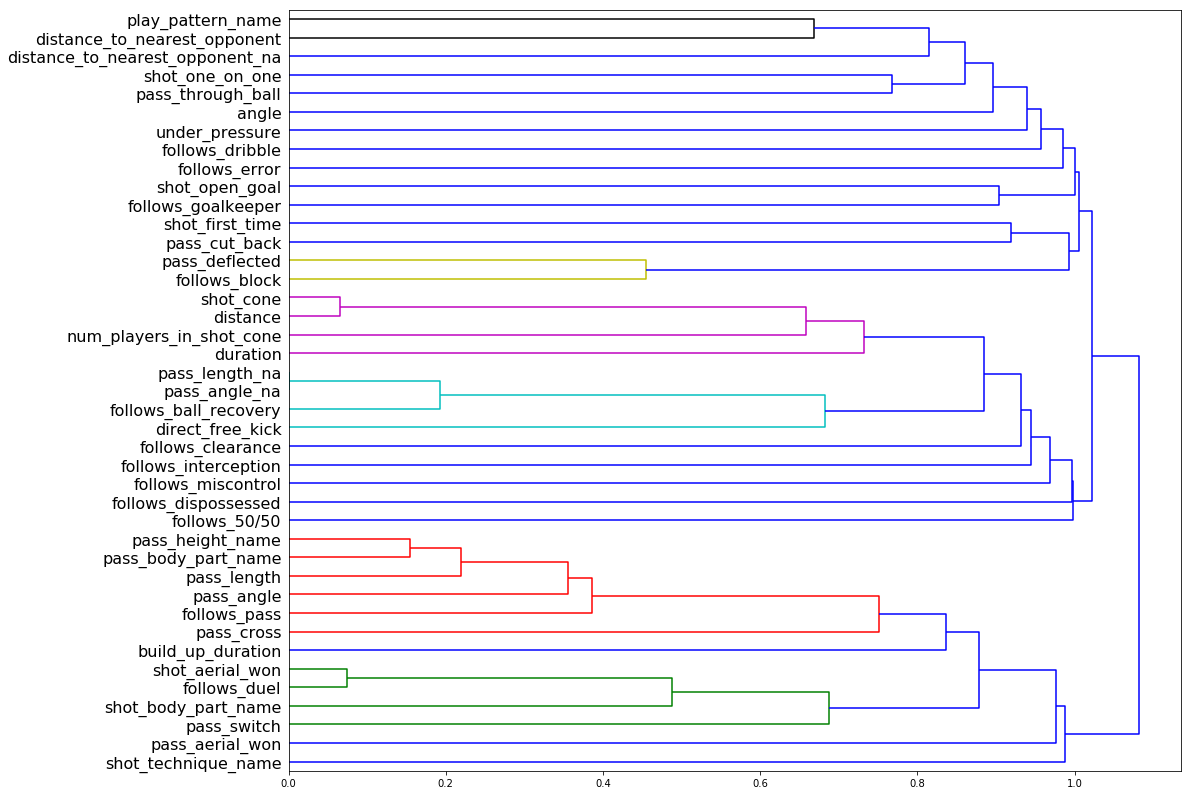

In [21]:
# Create dendrogram to show correlations between features
def dendrogram(X):
    # Compare features using rank correlation
    # https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(16,14))
    dendrogram = hc.dendrogram(z, labels=X.columns, 
          orientation='right', leaf_font_size=16)
    plt.show()
    return

dendrogram(X)

We can see from the dendrogram that 'shot_cone' and 'distance' are essentially measuring very similar things, as are 'shot_aerial_won' and 'follows_duel'. This isn't surprising; we could have guessed already that 'shot_cone' would be highly correlated to 'distance', since it's measuring the area of the triangle between the ball and the goalposts. We can also see some other groups, e.g. features like 'pass_height_name' and 'pass_body_part_name' are somewhat correlated. Let's try removing each of the correlated features in turn and see how this affects the Brier loss score.

In [22]:
# Try removing correlated features in turn to see what happens
# Each line of feats represents a group of correlated features
feats = ['shot_cone', 'distance',
         ['pass_angle_na', 'pass_length_na'], 'follows_ball_recovery',
         'shot_aerial_won', 'follows_duel',
         'pass_height_name', 'pass_body_part_name', 'pass_length', 'pass_angle', 'follows_pass']

print('original', "{0:.5f}".format(loss))
for feat in feats:
    loss_feats = get_loss(X=X.drop(feat, axis=1))   
    print(feat, "{0:.5f}".format(loss_feats))

original 0.07873
shot_cone 0.07836
distance 0.07987
['pass_angle_na', 'pass_length_na'] 0.07920
follows_ball_recovery 0.07897
shot_aerial_won 0.07902
follows_duel 0.07887
pass_height_name 0.07905
pass_body_part_name 0.07861
pass_length 0.07869
pass_angle 0.07910
follows_pass 0.07908


It looks like 'shot_cone', 'pass_body_part_name' and 'pass_length' are actually making the model worse, so we can definitely remove those. Getting rid of 'follows_ball_recovery' and 'follows_duel' from the other two groups did make the model slightly worse, although we know that a lot of the information from these features is also being captured in 'pass_angle_na' and 'shot_aerial_won' respectively. Since we can make our model simpler by removing these features without a significant change in Brier loss, we should go ahead and do so.

In [23]:
# Drop features that didn't make the loss score significantly worse
X1 = X.drop(['shot_cone', 'follows_ball_recovery', 'follows_duel', 'pass_body_part_name',
             'pass_length', 'pass_length_na'], axis=1)

loss1 = get_loss(X=X1)
print('Brier loss:', "{0:.5f}".format(loss1))

Brier loss: 0.07831


We are getting a loss of 0.07831 now, which is better than our original model. The next thing to do is to investigate removing other features that add little to no predictive value.

### Investigating feature importance
We have seen a method already that we can use to investigate feature importance, which we can call the 'drop-column method'. The steps are as follows:
- Train a model to calculate a baseline Brier loss score
- Remove each feature column in turn and calculate the loss score again
- The importance of a feature is the difference between the baseline score and the score produced when the feature is removed

This method is computationally expensive (i.e. slow), as we have to re-train a new model for every single feature column in our dataset. However, it produces reliable feature importance scores, which is what we are interested in here. Check out __[this excellent article](https://explained.ai/rf-importance/index.html)__ for some ideas of other methods you could use to calculate feature importance. Let's give the drop-column method a try and see what happens.

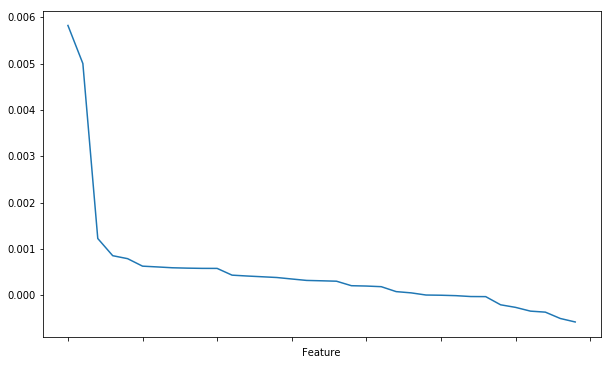

In [24]:
# Define a function to get feature importance using the drop-column method
def get_imp(X, y=y, m=m, cv=cv):
    baseline = get_loss(X=X, y=y, m=m, cv=cv)
    imp = []
    for col in X.columns:
        s = get_loss(X=X.drop(col, axis=1), y=y, m=m, cv=cv)
        change_in_score = s - baseline
        imp.append(change_in_score)
    imp_df = pd.DataFrame(data={'Feature': X.columns, 'Importance': np.array(imp)})
    imp_df = imp_df.set_index('Feature').sort_values('Importance', ascending=False)
    return imp_df

imp1 = get_imp(X=X1)
imp1.reset_index().plot('Feature', 'Importance', figsize=(10,6), legend=False); 

We can see from the plot above that most of the features don't affect the loss score that much, and some features actually make the model worse (importance <0 at the bottom-right of the plot). It looks like the feature importance starts to flatten off after a value of about 0.0005. Let's define a function to filter out features below a certain threshold, and test out some values between 0 and 0.0005 to try and find a good cut-off point.

In [26]:
# Define function to eliminate features that fall below a certain threshold
def elim_feats(X, imp, thresh):
    return X[list(imp[imp.values>thresh].index.values)]

# Create a list of 11 thresholds, evenly spaced between 0 and 0.0005
thresholds = [float(x) for x in np.linspace(start=0.0, stop=0.0005, num=11)]

# Calculate the loss for each threshold in the list
print('Original Brier loss:', "{0:.5f}".format(loss1))
for thresh in thresholds:
    X_elim = elim_feats(X=X1, imp=imp1, thresh=thresh)
    loss_elim = get_loss(X=X_elim)
    print('Threshold:', "{0:.5f}".format(thresh), 'Brier loss:', "{0:.5f}".format(loss_elim))

Original Brier loss: 0.07831
Threshold: 0.00000 Brier loss: 0.07844
Threshold: 0.00005 Brier loss: 0.07880
Threshold: 0.00010 Brier loss: 0.07817
Threshold: 0.00015 Brier loss: 0.07817
Threshold: 0.00020 Brier loss: 0.07877
Threshold: 0.00025 Brier loss: 0.07879
Threshold: 0.00030 Brier loss: 0.07879
Threshold: 0.00035 Brier loss: 0.07910
Threshold: 0.00040 Brier loss: 0.07952
Threshold: 0.00045 Brier loss: 0.08137
Threshold: 0.00050 Brier loss: 0.08137


It looks like our best bet is to remove features that have below 0.00015 importance. When doing so, we achieve an improved loss score of 0.07817.

Brier loss: 0.07817


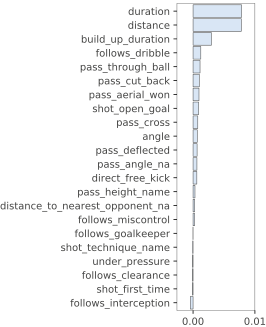

In [27]:
# Eliminate features below 0.00015 importance and rerun the model
X2 = elim_feats(X=X1, imp=imp1, thresh=0.00015)

loss2 = get_loss(X=X2)
imp2 = get_imp(X=X2)
print('Brier loss:', "{0:.5f}".format(loss2))
plot_importances(imp2, imp_range=(min(imp2.values), max(imp2.values)))

Note that after we remove some features we are still getting some that have <=0 importance. This is because we have calculated the feature importance again *relative to our new baseline score of 0.07817*. We will therefore be able to remove more features again later to simplify our model even further. First, let's look at a couple of these features in more detail to see if we can make them more useful.

### Investigating one-hot encoding
As you know by now, machine learning algorithms typically expect numeric inputs, so categorical features often need to be converted from strings to integers. So far we have been using 'label encoding' to do this, where each possible value of a categorical feature is converted to numeric. For example, looking at the mappings for 'shot_technique_name' shows us that 'Backheel' becomes 0, 'Diving Header' becomes 1, and so on.

In [39]:
print(mappings['shot_technique_name'])

{0: 'Backheel', 1: 'Diving Header', 2: 'Half Volley', 3: 'Lob', 4: 'Normal', 5: 'Overhead Kick', 6: 'Volley'}


An alternative technique is known as 'one-hot encoding', where each value of a category is converted to a new column containing ones (true) and zeroes (false). For example, when we one-hot encode 'shot_technique_name' using the pandas 'get_dummies' function, we end up with the following:

In [43]:
pd.get_dummies(X2['shot_technique_name'], prefix='shot_technique').head()

,shot_technique_0,shot_technique_1,shot_technique_2,shot_technique_3,shot_technique_4,shot_technique_5,shot_technique_6
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0


In this case the first four rows are 'shot_technique_4', i.e. normal shots, whereas the fifth row is a half volley. In __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__ I mentioned that one-hot encoding can often decrease the performance of models. However, we shouldn't always blindly rely on rules of thumb without testing them out ourselves! Let's try one-hot encoding 'shot_technique_name' and 'pass_height_name' to see if we can make them more useful.

In [38]:
# Try one-hot encoding some features to see if we can make them more useful
one_hot = ['pass_height_name', 'shot_technique_name']

for feat in one_hot:
    X_one_hot = pd.concat([X2, pd.get_dummies(X2[feat], prefix=feat)], axis=1)
    X_one_hot.drop(feat, axis=1, inplace=True)
    loss_one_hot = get_loss(X=X_one_hot)   
    print(feat, "{0:.5f}".format(loss_one_hot))

pass_height_name 0.07842
shot_technique_name 0.07782


Our model gets worse when we one-hot encode 'pass_height_name', but we see an improvement with 'shot_technique_name'. Let's look at the new feature importance plot to try and see what is happening.

Brier loss: 0.07782


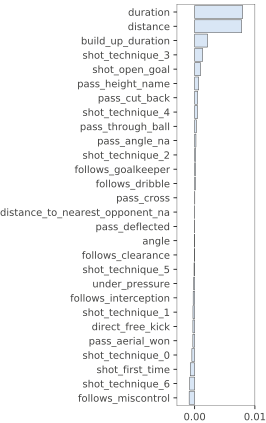

In [29]:
# One-hot encode shot_technique_name
X3 = pd.concat([X2, pd.get_dummies(X2['shot_technique_name'], prefix='shot_technique')], axis=1)
X3.drop('shot_technique_name', axis=1, inplace=True)

loss3 = get_loss(X=X3)
imp3 = get_imp(X=X3)
print('Brier loss:', "{0:.5f}".format(loss3))
plot_importances(imp3, imp_range=(min(imp3.values), max(imp3.values)))

The advantage of one-hot encoding is that we can now see the importance of each value in a category individually, rather than just the importance of the overall feature itself. With enough split points a decision tree can work this out anyway, but one-hot encoding can sometimes help to make this process easier. In this case it looks like our model is assigning quite a high importance to lob shots, whereas volleys are actually hurting the performance. There area only 25 examples of lob shots in the dataset, so not many, but it's certainly interesting that they appear to be quite significant.

It's now a good idea to eliminate some more features and re-run the model. In this case we'll just get rid of all the features that have <=0 importance, which should hopefully improve our loss score again.

Brier loss: 0.07764


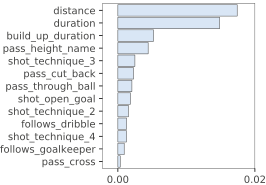

In [35]:
# Eliminate features <=0 importance and re-run the model
X4 = elim_feats(X=X3, imp=imp3, thresh=0)
# Also get rid of pass_angle_na, as pass_angle is no longer a model feature
X4 = X4.drop('pass_angle_na', axis=1)

loss4 = get_loss(X=X4)
imp4 = get_imp(X=X4)
print('Brier loss:', "{0:.5f}".format(loss4))
plot_importances(imp4, imp_range=(min(imp4.values), max(imp4.values)))

We now have just 13 features again, the same as our original model, but most of these are new inputs that we just added. The results aren't drastically different to before, but our Brier loss score did improve slightly, which is what we were hoping for.

### Investigating partial dependence plots
'Distance' and 'duration' are by far the two most important features in our model, but we don't really know why they are important. A nice way to investigate this is to look at a partial dependence plot, which essentially shows how a particular feature affects the model predictions, all else being equal. Let's use the '__[pdpbox](https://pdpbox.readthedocs.io/en/latest/index.html)__' module to create plots for 'distance' and 'duration'.

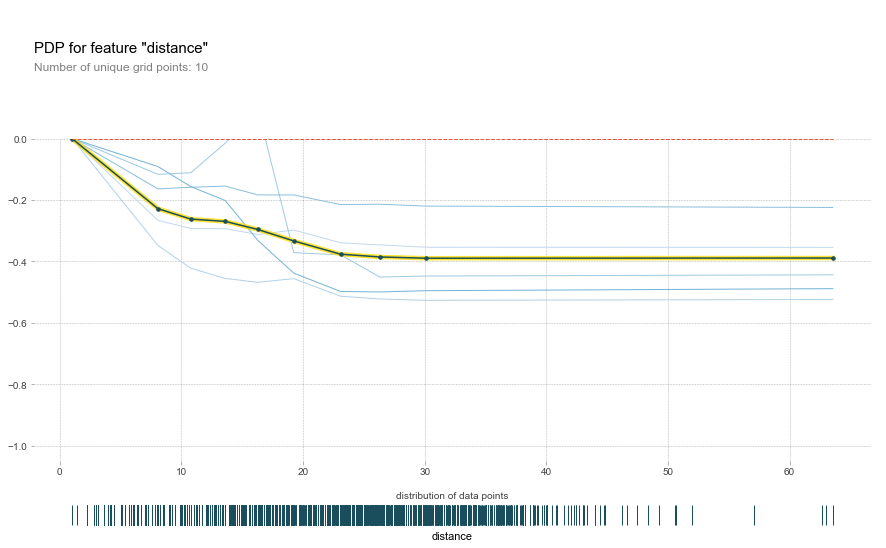

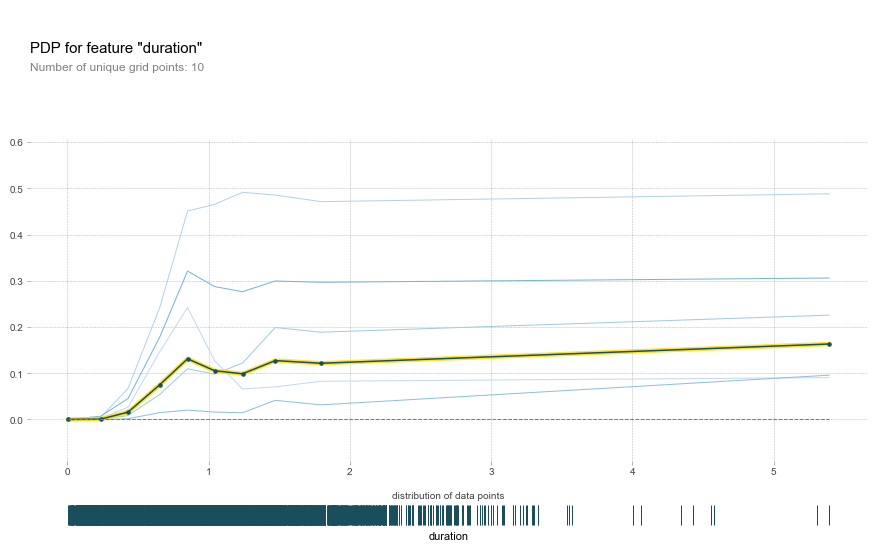

In [36]:
from pdpbox import pdp # pip install first

# Define a function to create a pdp for a particular model feature
# Setting clusters=5 will group the predictions for each row in the dataset into 5 clusters
def plot_pdp(X, feat, model=m, clusters=5, feat_name=None, y=y):
    m.fit(X, y)
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model=m, dataset=X, model_features=X.columns, feature=feat)
    fig, ax = pdp.pdp_plot(p, feat_name, plot_lines=True, plot_pts_dist=True, 
                           cluster=clusters is not None, n_cluster_centers=clusters);
    return

plot_pdp(X=X4, feat='distance')
plot_pdp(X=X4, feat='duration')

The first PDP shows that as distance increases, the model assigns a lower chance of a goal. This is exactly what we would expect to happen, so it's nice to see that in action! The second PDP shows the opposite behaviour, so the longer the duration of a shot event the more likely it is that the result is a goal. I wouldn't have guessed this before creating models, which certainly makes me appreciate the value of machine learning. There are a lot more cool things you can do with pdpbox, so I suggest playing around with some more plots on your own to see what you can find out!

## Conclusion
Thanks very much for reading! Hopefully you enjoyed working through the notebook and have learned a lot of useful things about feature engineering for machine learning models. If you have, please help me out by sharing this on social media!

In part 10 we'll be looking at how to tune model hyperparameters to improve performance even further, so make sure to follow __[@fantasyfutopia](https://twitter.com/fantasyfutopia)__ and __[@tom_whelan](https://twitter.com/tom_whelan)__ so you don't miss it.

This notebook was produced with the help of __[StatsBomb](https://statsbomb.com/)__ data.

In [37]:
# Save data so we can use it in part 10
data = X4.join(y)
data.to_csv('data.csv')